In [1]:
#Use miniconda-analysis environment
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import co2_timeseries_tools as co2tt
from scipy import stats
from scipy import signal
from ctsm_py import utils
import pandas as pd
from matplotlib.ticker import MaxNLocator

# Observational Data

Add additional observed data as text files, then add to ESRL list

In [2]:
path='/glade/work/dll/CTSM_py/notebooks/'
mlo={'name':'Mauna Loa', 'acronym': 'mlo', 'lat': 19.5, 'lon':360-155.6, 'z':3397.0}
alt={'name':'Alert', 'acronym': 'alt', 'lat': 82.5, 'lon':360-62.5, 'z':200.0}
azr={'name': 'Azores', 'acronym':'azr','lat':38.8, 'lon':360-27.4, 'z':19.0}
cba={'name': 'Cold Bay', 'acronym':'cba', 'lat':55.2, 'lon':360-162.7, 'z':21.3}
kum={'name':'Kumukahi', 'acronym':'kum', 'lat':19.7, 'lon':360-155.0, 'z':0.3}
nwr={'name':'Niwot Ridge', 'acronym':'nwr', 'lat':40.1, 'lon':360-105.6, 'z':3523.0}
brw={'name':'Barrow', 'acronym': 'brw',  'lat': 71.3, 'lon':360-156.61, 'z': 11.0}

## Select and run for either all or subset of sites
Choose and run only one of the two next cells

In [3]:
# All available sites
ESRL=[brw, mlo, alt, azr, cba, kum, nwr]

#Below arrays used for selecting CESM points
lats=np.array([71.3,19.5,82.5,38.8,55.2,19.7,40.1])
lons=np.array([360-156.61,360-155.6,360-62.5,360-27.4,360-162.7,360-155.0,360-105.6])
#note that the 'lev' variable only goes from 0 to 1000, not sure how to translate from 'alt' to 'lev'
alt=np.array([11.0,3397.0,200.0,19.0,21.3,0.3,3523.0])
#cesm1levs=np.array([25,20,25,25,25,25,20])
#cesm2levs=np.array([31,22,31,31,31,31,22])
cesm1levs=np.array([25,25,25,25,25,25,25])
cesm2levs=np.array([31,31,31,31,31,31,31])

In [3]:
#Subset of sites
ESRL=[kum, mlo, nwr, brw]

#Below arrays used for selecting CESM points
lats=np.array([19.7,19.5,40.1,71.3])
lons=np.array([360-155.0,360-155.6,360-105.6,360-156.61])
alt=np.array([0.3,3397.0,3523.0,11.0])
cesm1levs=np.array([25,20,20,25])
cesm2levs=np.array([31,22,22,31])
#cesm1levs=np.array([25,25,25])
#cesm2levs=np.array([31,31,31])

### Looping over all observational sites to read in file

In [4]:
minYear = 1981 # minimum year for an 'early' trend, used later for plotting
dfs = []

for site in ESRL:
#    print(site)
    filename=path+'co2_'+site['acronym']+'_surface-flask_1_ccgg_month.txt'
    #import glob
    #filename=glob.glob(partialname+ '*co2')
    with open(filename, 'r') as fid:
        first_line=fid.readline()
        nheader=first_line[-3:-1]
        nheader=np.int(np.float(nheader))
    data=np.loadtxt(filename, usecols=(1,2,3), skiprows=nheader)
    time=data[:,0]+data[:,1]/12
    co2=data[:,2]
    month=data[:,1]
    year=data[:,0]
    site['year']=year.astype(int)
    site['month']=month.astype(int)
    site['co2']=co2
    dfs.append(pd.DataFrame(site)) #turn dictionary into a pandas dataframe
    
    # detrended annual cycle using Gretchen's functions
    # done w/in this loop for ease
    # how many years of data needed in function? 
    print(site['acronym']+' first year '+str(min(year)) )
#NOTE: change minYear loop to set comparable times for CESM simulations? 
    if min(year) < minYear:
        j=np.where(year<(minYear+1))
        early_co2detrend=co2tt.poly3detrend(year[j], month[j], co2[j])
        early_co2mm=co2tt.compute_mm(month[j], early_co2detrend)
        early_co2sd=co2tt.compute_msdev(month[j], early_co2detrend)
        site['early_co2detrend'] = early_co2detrend
        site['early_co2mm'] = early_co2mm
        site['early_co2sd'] = early_co2sd
        
    
#Similar to above, set time to be similar to CESM simulations?
    # Repeat for the end of the record
    j=np.where(year>2010)
#Note: haven't yet verified that this works
#    j=np.where(2005<year>2015)
    late_co2detrend=co2tt.poly3detrend(year[j], month[j], co2[j])
    late_co2mm=co2tt.compute_mm(month[j], late_co2detrend)
    late_co2sd=co2tt.compute_msdev(month[j], late_co2detrend)
    site['late_co2detrend'] = late_co2detrend
    site['late_co2mm'] = late_co2mm
    site['late_co2sd'] = late_co2sd
    
df = pd.concat(dfs)
df['time'] = pd.to_datetime(df.year.astype('str') + '-' + df.month.astype('str'))

kum first year 1976.0
mlo first year 1959.0
nwr first year 1968.0
brw first year 1971.0


### Plot full time series at each site

[19.7, 19.5, 40.1, 71.3]


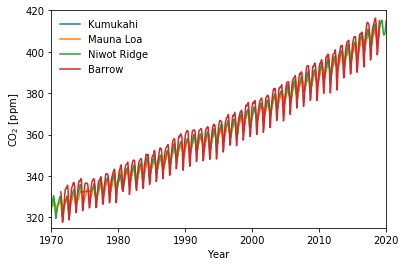

In [5]:
# made a list to store site names more easily
labels = [''] * len(ESRL)
obsLat = [np.nan] * len(ESRL)
obsLon = [np.nan] * len(ESRL)
obsEle = [np.nan] * len(ESRL)

#loop through each of the sites [i] in ESRL
for i in range(len(ESRL)):
    plt.plot(ESRL[i]['year']+ESRL[i]['month']/12.0, ESRL[i]['co2'])
    plt.ylabel(r'CO$_2$ [ppm]')
    plt.xlabel('Year')
    plt.ylim(315,420)
    plt.xlim(1970,2020)
    labels[i] = ESRL[i]['name'] 
    obsLat[i] = ESRL[i]['lat'] 
    obsLon[i] = ESRL[i]['lon'] 
    obsEle[i] = ESRL[i]['z'] 
plt.legend(labels=labels, frameon=False);

print(obsLat)
#plt.savefig('BRWTimeseries.eps')

# Model Data
Code converted from ~/AmplitudeAnalysis/CESM_CO2AmpTrend_Regions_Altitude_withNoFert.ncl

Defining directories and simulation names

In [6]:
simyrs             = "185001-201412"
var                = "CO2"

datadir            = "/glade/p/cesm/lmwg_dev/dll/"
subdir             = "/atm/proc/tseries/month_1/"
Mod1dir            = "CESM2_Coupled_NoCrop/"
Mod2dir            = "CESM2_Coupled_NoFert/"

sim                = "b.e21.BHIST_BPRP.f09_g17.CMIP6-esm-hist.001"
sim2               = "b40.20th.1deg.coup.001"
sim3               = "b.e21.BHIST_BPRP.f09_g17.CMIP6-esm-hist.002_NoCropSpin_Transient1970-2014"
sim4               = "b.e21.BHIST_BPRP.f09_g17.CMIP6-esm-hist.002_NoFert_Transient1970-2014"

In [ ]:
#Old code, not currently working
#data1          = utils.time_set_mid(xr.open_dataset(datadir+Mod1dir+sim+".cam.h0."+var+"."+simyrs+".nc", decode_times=True), 'time')
#data2          = utils.time_set_mid(xr.open_dataset(datadir+Mod1dir+sim2+".cam2.h0."+var+".185001-200512.nc", decode_times=True), 'time')
#data3          = utils.time_set_mid(xr.open_dataset(datadir+Mod1dir+subdir+sim3+".cam.h0."+var+".197001-201412.nc", decode_times=True), 'time')
#data4          = utils.time_set_mid(xr.open_dataset(datadir+Mod2dir+subdir+sim4+".cam.h0."+var+".197001-201412.nc", decode_times=True), 'time')

Reading in simulations

In [7]:
data1          = xr.open_dataset(datadir+Mod1dir+sim+".cam.h0."+var+"."+simyrs+".nc")
data1          = data1.assign_coords(time=data1.time_bnds.mean('nbnd'))
data2          = xr.open_dataset(datadir+Mod1dir+sim2+".cam2.h0."+var+".185001-200512.nc")
data2          = data2.assign_coords(time=data2.time_bnds.mean('tbnd'))
data3          = xr.open_dataset(datadir+Mod1dir+subdir+sim3+".cam.h0."+var+".197001-201412.nc")
data3          = data3.assign_coords(time=data3.time_bnds.mean('nbnd'))
data4          = xr.open_dataset(datadir+Mod2dir+subdir+sim4+".cam.h0."+var+".197001-201412.nc")
data4          = data4.assign_coords(time=data4.time_bnds.mean('nbnd'))

 From Anderson
 ds.info()
 Functions similar to ncdump -- gives info from a dataset.

Also:
var.shape, var.dim
returns data shape and number of dimensions
Can chain using sel and isel:
ds.tas.isel(time=0).sel(lon=slice(20, 160), lat=slice(-80, 25))

For plotting, can use interactive hvplot:
import hvplot.xarray

### Converting to units of 'ppm'

In [8]:
#conversion of CESM CO2 to ppm
convert = 10.0**6 * 28.966/44.0

### Calculating altitude at each level

#### This might be faster if I move convert to the points below -- less data to convert

In [9]:
CESM1ppm = data2.CO2.sel(time=slice('1950','2014')) 
CESM2ppm = data1.CO2.sel(time=slice('1950','2014')) 

In [10]:
#Calculating appropriate layer based on altitude
#Based on correspondence with Isla
#currently not using
H = 7000
ps = 1000
plev2 = CESM2ppm.lev
plev1 = CESM1ppm.lev
zCESM1 = -H*np.log(plev1/ps)
zCESM2 = -H*np.log(plev2/ps)

### Pulling out data for each site

In [11]:
#initialize list using '[]' and dictionary using '{}'
CESM1points = {}
CESM2points = {}

#lat and lon are actual values to pull out, level refers to a specific index, not a value, so requires 'isel'
for x in range(len(ESRL)):
    CESM1pointloop = CESM1ppm.sel(lat=lats[x], lon=lons[x], method="nearest")
    CESM2pointloop = CESM2ppm.sel(lat=lats[x], lon=lons[x], method="nearest")
    CESM1pointloop = CESM1pointloop.isel(lev=cesm1levs[x])
    CESM2pointloop = CESM2pointloop.isel(lev=cesm2levs[x])
    CESM1points[x] = CESM1pointloop * convert
    CESM2points[x] = CESM2pointloop * convert
    

### Testing methods for point selection
For testing only

In [17]:
# methods: nearest, ffill, backfill; in a test for the last point, nearest seems to be the closest to value
CESM1ppm.sel(lat=lats[1], lon=lons[1], method="nearest")

<xarray.DataArray 'CO2' (time: 672, lev: 26)>
array([[0.000474, 0.000473, 0.000473, ..., 0.000478, 0.000478, 0.000478],
       [0.000474, 0.000474, 0.000474, ..., 0.000479, 0.000479, 0.000479],
       [0.000474, 0.000474, 0.000474, ..., 0.000479, 0.00048 , 0.00048 ],
       ...,
       [0.000595, 0.000596, 0.000596, ..., 0.000604, 0.000604, 0.000604],
       [0.000596, 0.000596, 0.000596, ..., 0.000606, 0.000606, 0.000606],
       [0.000597, 0.000596, 0.000597, ..., 0.000608, 0.000608, 0.000608]],
      dtype=float32)
Coordinates:
    lat      float64 19.32
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
    lon      float64 205.0
  * time     (time) object 1950-01-16 12:00:00 ... 2005-12-16 12:00:00
Attributes:
    units:         kg/kg
    long_name:     CO2
    cell_methods:  time: mean

In [15]:
CESM2points

{0: <xarray.DataArray 'CO2' (time: 780)>
 array([323.33524, 323.19415, 322.9817 , ..., 417.31024, 423.22888, 422.63565],
       dtype=float32)
 Coordinates:
     lat      float64 71.15
     lon      float64 203.8
     lev      float64 992.6
   * time     (time) object 1950-01-16 12:00:00 ... 2014-12-16 12:00:00,
 1: <xarray.DataArray 'CO2' (time: 780)>
 array([320.11057, 320.5138 , 320.63745, ..., 415.06143, 416.3286 , 417.81335],
       dtype=float32)
 Coordinates:
     lat      float64 19.32
     lon      float64 205.0
     lev      float64 691.4
   * time     (time) object 1950-01-16 12:00:00 ... 2014-12-16 12:00:00,
 2: <xarray.DataArray 'CO2' (time: 780)>
 array([322.9406 , 323.07074, 322.8356 , ..., 414.81784, 419.18265, 422.41507],
       dtype=float32)
 Coordinates:
     lat      float64 82.46
     lon      float64 297.5
     lev      float64 992.6
   * time     (time) object 1950-01-16 12:00:00 ... 2014-12-16 12:00:00,
 3: <xarray.DataArray 'CO2' (time: 780)>
 array([321.54413

In [10]:
CESM1points[0]
#CESM1points[0].values

<xarray.DataArray 'CO2' (time: 672)>
array([318.79465, 318.19614, 318.6277 , ..., 397.42105, 401.92096, 405.65616],
      dtype=float32)
Coordinates:
    lat      float64 71.15
    lev      float64 992.6
    lon      float64 203.8
  * time     (time) object 1950-01-16 12:00:00 ... 2005-12-16 12:00:00
Attributes:
    units:    ppm

In [ ]:
CESM1points[1]

for site, data in CESM1points.items():
    print(data.lat.values, data.lon.values, site)

In [ ]:
print(data)

### End code testing

### CESM data: Calculating amplitude for each site

In [12]:
CESM1amp = {}
CESM2amp = {}
for site, data in CESM1points.items():
    amp  = data.resample(time="Y").max() - data.resample(time="Y").min()
    amp_norm = amp - amp.isel(time=0)
    CESM1amp[site] = amp
    CESM1amp[site]['time'] = CESM1amp[site]['time.year']
    
for site, data in CESM2points.items():
    amp  = data.resample(time="Y").max() - data.resample(time="Y").min()
    amp_norm = amp - amp.isel(time=0)
    CESM2amp[site] = amp
    CESM2amp[site]['time'] = CESM2amp[site]['time.year']

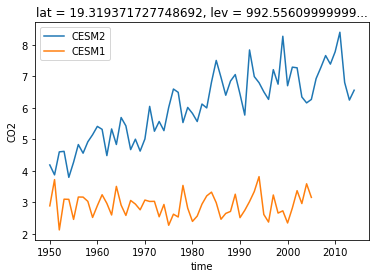

In [13]:
#Checking plot
CESM2amp[0].plot(label="CESM2")
CESM1amp[0].plot(label="CESM1")
plt.legend()

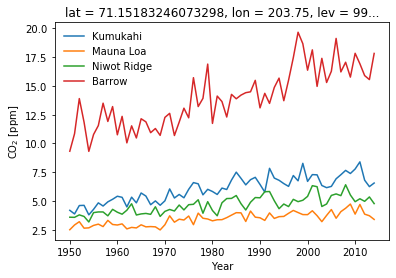

In [14]:
for site, data in CESM2amp.items():
    labels[i] = ESRL[i]['name']
    data.plot()
    plt.ylabel(r'CO$_2$ [ppm]')
    plt.xlabel('Year')
plt.legend(labels=labels, frameon=False)

### Obs data: Calculating amplitude for each site


In [15]:
#FROM ANDERSON
#see: https://gist.github.com/andersy005/f1915d2202cddecaa15be2a9704c181d
#Note: still need to remove years when there are <12 values per year when using all sites

ds = df.set_index(['time', 'name'])[['co2']].to_xarray()
ds = ds.reindex(name=["Kumukahi","Mauna Loa", "Niwot Ridge", "Barrow"])

grouped = ds.groupby('name')
dsets = []
for site, dataset in grouped:
    g = dataset.groupby('time.year')
    r = (g.max() - g.min())
    dsets.append(r)
x = xr.concat(dsets, dim='name')

#x.co2.plot(col='name', col_wrap=3)


In [16]:
#ds

## Code fragments not working properly. Do not use 

/glade/u/home/dll/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()
/glade/u/home/dll/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: All-NaN slice encountered


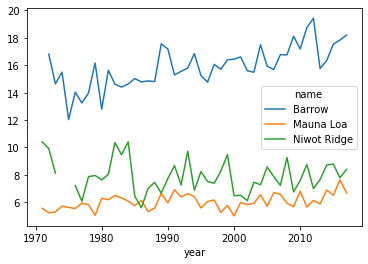

In [22]:
#From Will
#Can't get this to run
#convert to pandas dataframe
df = pd.DataFrame(ESRL,columns = ['name','year','co2'])

# create arrays to hold results (here xr)
# nobs will be used to count obs for each year & mask values when < 12
years = range(int(ESRL[0].get('year').min()),int(ESRL[0].get('year').max()))
minCO2 = xr.DataArray(np.nan, coords={'name': df.name, 'year':years}, dims=['name','year'])
maxCO2 = xr.DataArray(np.nan, coords={'name': df.name, 'year':years}, dims=['name','year'])
nobs   = xr.DataArray(np.nan, coords={'name': df.name, 'year':years}, dims=['name','year'])
# loop through each site & year
for i in range(len(df.name)):
    for j in range(len(years)):
        temp = np.where(ESRL[i]['year']==years[j],ESRL[i]['co2'],np.nan)
        maxCO2[i,j] = np.nanmax(temp) 
        minCO2[i,j] = np.nanmin(temp)
        nobs[i,j] = np.isnan(temp)[np.isnan(temp) == False].size

ampCO2 = maxCO2 - minCO2
ampCO2 = ampCO2.where(nobs==12)
ampCO2.plot.line(hue='name',x='year');

In [23]:
#use set_index to keep some of these as metadata instead of array
ds = df.set_index(['time', 'name'])[['co2']].to_xarray()
ds

KeyError: "None of ['time'] are in the columns"

In [19]:
ds_min = ds.groupby('time.year').min(['z', 'lat', 'lon', 'time'])
ds_max = ds.groupby('time.year').max(['z', 'lat', 'lon', 'time'])

ValueError: Dataset does not contain the dimensions: ['z', 'lon', 'lat']

In [21]:
obsampCO2 = ds_max - ds_min
obsampCO2

<xarray.Dataset>
Dimensions:  (name: 7, year: 52)
Coordinates:
  * name     (name) object 'Alert' 'Azores' ... 'Mauna Loa' 'Niwot Ridge'
  * year     (year) int64 1968 1969 1970 1971 1972 ... 2015 2016 2017 2018 2019
Data variables:
    co2      (year, name) float64 nan nan nan nan nan ... nan nan nan nan 7.2

#### How do I remove years that don't have data for all months?

In [45]:
# not sure this is doing what I want
nobs = np.isnan(ds.groupby('time.year'))
nobs

<xarray.Dataset>
Dimensions:  (lat: 7, lon: 7, name: 7, time: 624, z: 7)
Coordinates:
  * name     (name) object 'Alert' 'Azores' ... 'Mauna Loa' 'Niwot Ridge'
  * z        (z) float64 0.3 11.0 19.0 21.3 200.0 3.397e+03 3.523e+03
  * lat      (lat) float64 19.5 19.7 38.8 40.1 55.2 71.3 82.5
  * lon      (lon) float64 197.3 203.4 204.4 205.0 254.4 297.5 332.6
  * time     (time) datetime64[ns] 1968-01-01 1968-02-01 ... 2019-12-01
Data variables:
    co2      (name, time, z, lat, lon) bool True True True ... True True True
    year     (time) int64 1968 1968 1968 1968 1968 ... 2019 2019 2019 2019 2019

In [50]:
# attempting to remove years when not all data are available
# if not all months are there, will skew amplitude calculations
obsampCO2_fullyr = obsampCO2.where(nobs==12)
obsampCO2_fullyr

<xarray.Dataset>
Dimensions:  (lat: 7, lon: 7, name: 7, time: 624, year: 52, z: 7)
Coordinates:
  * name     (name) object 'Alert' 'Azores' ... 'Mauna Loa' 'Niwot Ridge'
  * year     (year) int64 1968 1969 1970 1971 1972 ... 2015 2016 2017 2018 2019
  * z        (z) float64 0.3 11.0 19.0 21.3 200.0 3.397e+03 3.523e+03
  * lat      (lat) float64 19.5 19.7 38.8 40.1 55.2 71.3 82.5
  * lon      (lon) float64 197.3 203.4 204.4 205.0 254.4 297.5 332.6
  * time     (time) datetime64[ns] 1968-01-01 1968-02-01 ... 2019-12-01
Data variables:
    co2      (year, name, time, z, lat, lon) float64 nan nan nan ... nan nan nan

#### Need to figure out how to plot obs amplitude calculation

In [22]:
obsampCO2_array = obsampCO2.to_array()
obsampCO2_array

<xarray.DataArray (variable: 1, year: 52, name: 7)>
array([[[  nan,   nan, ...,   nan,  8.32],
        [  nan,   nan, ...,  3.04,  9.39],
        ...,
        [16.27, 11.55, ...,  6.  ,  8.53],
        [  nan,   nan, ...,   nan,  7.2 ]]])
Coordinates:
  * name      (name) object 'Alert' 'Azores' ... 'Mauna Loa' 'Niwot Ridge'
  * year      (year) int64 1968 1969 1970 1971 1972 ... 2015 2016 2017 2018 2019
  * variable  (variable) <U3 'co2'

## End code fragments

### Plot testing

#### Works for obs, can I easily add other data & change colors? 

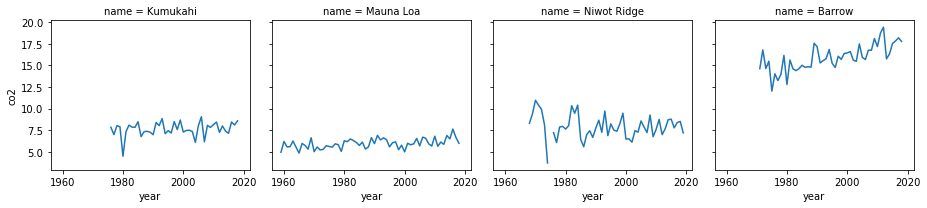

In [17]:
# Specify "time" in min, max so that the "name" dimension is preserved
x2 = ds.groupby("time.year").map(lambda g: g.max("time") - g.min("time"))
x2.co2.plot(col="name")  #  'facet' using the 'col' kwarg

/glade/u/home/dll/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b4f77806dd8>,
      dtype=object)

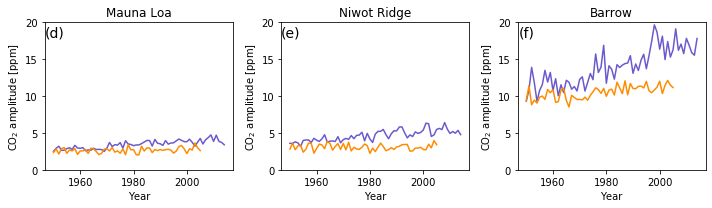

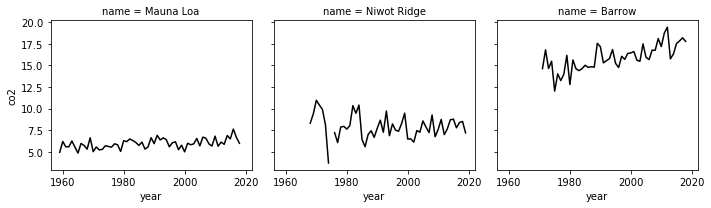

In [39]:
panel = ['(d)','(e)','(f)'] #to label panels
fig = plt.figure(figsize=(10,3))
plt.subplots_adjust(hspace=0.01, wspace=0.01)

for i,(site, data) in enumerate (CESM2amp.items()):
#previous loop: for sim_name, data in sims.items():
    ax = fig.add_subplot(1,4,i+1)
    data.plot(color='slateblue', label='CESM2')
    
for i,(site, data) in enumerate (CESM1amp.items()):
#    labels[i] = ESRL[i]['name']
    ax = fig.add_subplot(1,4,i+1)
    data.plot(color='darkorange', label='CESM1')
    plt.title(labels[i])
    plt.ylabel(r'CO$_2$ amplitude [ppm]')
    plt.xlabel('Year')
    plt.ylim(0,20)
    plt.tight_layout()
    plt.text(0.05, 0.93,panel[i], fontsize=14,
     ha='center', va='center', transform=plt.gca().transAxes)

fig = x2.co2.plot(col="name", color='black', label='observations')

#### End Plot Testing

## Plotting amplitude time series

/glade/u/home/dll/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/glade/u/home/dll/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/glade/u/home/dll/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Tight layout not applied. tight_layout cann

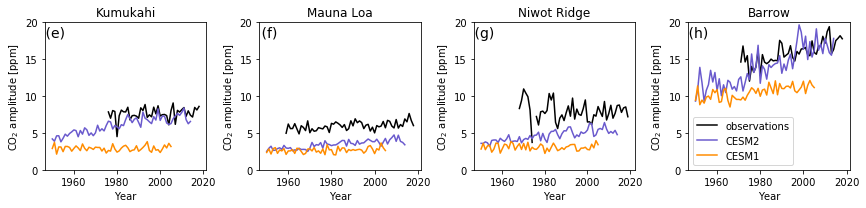

In [34]:
# Plot ensemble averages and spread for each model version?
panel = [' (e)',' (f)',' (g)',' (h)'] #to label panels
fig = plt.figure(figsize=(12,3))
plt.subplots_adjust(hspace=0.01, wspace=0.01)
#plt.ylabel(r'CO$_2$ amplitude [ppm]')
#plt.subplots(sharey=True)

for i in range(len(x.name)):
    ax = fig.add_subplot(1,4,i+1)
# Use for reindex; still not plotting proper order with reindex
    data = x2.co2[:,i]
#    data = x.co2[i,:]
    data.plot(color='black', label='observations')

for i,(site, data) in enumerate (CESM2amp.items()):
#previous loop: for sim_name, data in sims.items():
    ax = fig.add_subplot(1,4,i+1)
    data.plot(color='slateblue', label='CESM2')
    
for i,(site, data) in enumerate (CESM1amp.items()):
#    labels[i] = ESRL[i]['name']
    ax = fig.add_subplot(1,4,i+1)
    data.plot(color='darkorange', label='CESM1')
    plt.title(labels[i])
    plt.ylabel(r'CO$_2$ amplitude [ppm]')
    plt.xlabel('Year')
    plt.ylim(0,20)
    plt.tight_layout()
    plt.text(0.05, 0.93,panel[i], fontsize=14,
     ha='center', va='center', transform=plt.gca().transAxes)

plt.legend()
plt.savefig('amp_timeseries.pdf')

#Below resources can help to share axes to reduce space/noise
#Can't figure out how to get them to work in my loops
#sharexy    
#sharey=row


### Calculating annual cycle for each site

In [21]:
CESM1_ann_early = {}
CESM1_ann_late  = {}
CESM2_ann_early = {}
CESM2_ann_late  = {}
CESM1_ann_early_detrend = {}
CESM1_ann_late_detrend  = {}
CESM2_ann_early_detrend = {}
CESM2_ann_late_detrend  = {}
CESM1_ann_late_detrend_SD = {}
CESM2_ann_late_detrend_SD = {}

for site, data in CESM1points.items():
    CESM1late   = data.sel(time=slice('2000','2015'))
    CESM1early  = data.sel(time=slice('1980','1985'))
    CESM1_ann_late[site] = CESM1late.groupby("time.month").mean()
    CESM1_ann_early[site] = CESM1early.groupby("time.month").mean()
    CESM1_ann_early_detrend[site] = xr.DataArray(signal.detrend(CESM1early),coords={'time':CESM1early.time}, dims='time').groupby("time.month").mean()
    CESM1_ann_late_detrend[site] = xr.DataArray(signal.detrend(CESM1late),coords={'time':CESM1late.time}, dims='time').groupby("time.month").mean()
    CESM1_ann_late_detrend_SD[site] = xr.DataArray(signal.detrend(CESM1late),coords={'time':CESM1late.time}, dims='time').groupby("time.month").std()

for site, data in CESM2points.items():
    CESM2late   = data.sel(time=slice('2000','2015'))
    CESM2early  = data.sel(time=slice('1980','1985'))
    CESM2_ann_late[site] = CESM2late.groupby("time.month").mean()
    CESM2_ann_early[site] = CESM2early.groupby("time.month").mean()
    CESM2_ann_early_detrend[site] = xr.DataArray(signal.detrend(CESM2early),coords={'time':CESM2early.time}, dims='time').groupby("time.month").mean()
    CESM2_ann_late_detrend[site] = xr.DataArray(signal.detrend(CESM2late),coords={'time':CESM2late.time}, dims='time').groupby("time.month").mean()
    CESM2_ann_late_detrend_SD[site] = xr.DataArray(signal.detrend(CESM2late),coords={'time':CESM2late.time}, dims='time').groupby("time.month").std()


## plot an annual cycle
#### Note that early cycle, obs years aren't consistent with model years

### Early Amplitude Plots

/glade/u/home/dll/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/glade/u/home/dll/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


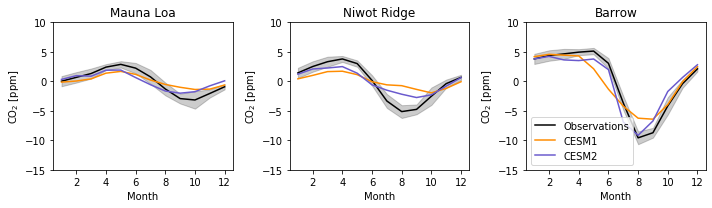

In [44]:
#Early Amplitude Plots
month = CESM1_ann_late_detrend[0].month.astype(int)
fig = plt.figure(figsize=(10,3))
plt.subplots_adjust(hspace=0.01, wspace=0.01)
panel_bot = ['(d)','(e)','(f)','(g)'] #to label panels

for i in range(len(ESRL)):
    if min(ESRL[i]['year']) < minYear:
        early_co2mm = ESRL[i]['early_co2mm']
    ax = fig.add_subplot(1,3,i+1)    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.plot(month, early_co2mm, color='black', label="Observations")
    plt.fill_between(month, early_co2mm-late_co2sd, early_co2mm+late_co2sd, color='black', alpha=0.2)

#    plt.plot(early_co2mm, color='black', label="Observations")

for i,(site, data) in enumerate (CESM1_ann_early_detrend.items()):
    ax = fig.add_subplot(1,3,i+1)
    data.plot(color='darkorange',label="CESM1")
    
for i,(site, data) in enumerate (CESM2_ann_early_detrend.items()):
    ax = fig.add_subplot(1,3,i+1)
    data.plot(color='slateblue',label="CESM2")
    plt.title(labels[i])
    plt.ylabel(r'CO$_2$ [ppm]')
    plt.xlabel('Month')
    plt.ylim(-15,10)
    plt.tight_layout()
    # add panel label to top left
#    plt.text(0.05, 0.93,panel_bot[i], fontsize=14,
#         ha='center', va='center', transform=plt.gca().transAxes)
    # add panel label to bottom left
#    plt.text(0.05, 0.05,labels[i], fontsize=14,
#         ha='left', va='center', transform=plt.gca().transAxes)

plt.legend()

### Late Amplitude Plots

/glade/u/home/dll/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/glade/u/home/dll/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


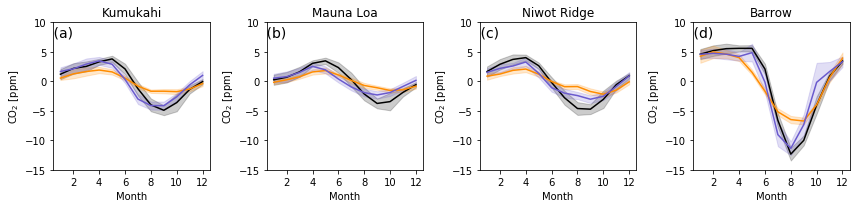

In [36]:
month = CESM1_ann_late_detrend[0].month.astype(int)
panel_bot = [' (a)',' (b)',' (c)',' (d)'] #to label panels
fig = plt.figure(figsize=(12,3))
plt.subplots_adjust(hspace=0.01, wspace=0.01)

for i in range(len(ESRL)):
    late_co2mm  = ESRL[i]['late_co2mm']
    ax = fig.add_subplot(1,4,i+1)    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.plot(month, late_co2mm, color='black', label="Observations")
#    plt.fill_between(month, late_co2mm-late_co2sd, late_co2mm-late_co2sd, color='black', alpha=0.2)
    plt.fill_between(month, late_co2mm-late_co2sd, late_co2mm+late_co2sd, color='black', alpha=0.2)

for i,(site, data) in enumerate (CESM1_ann_late_detrend.items()):
    ax = fig.add_subplot(1,4,i+1)
    data.plot(color='darkorange', label='CESM1')
    plt.fill_between(CESM1_ann_late_detrend[i].month, CESM1_ann_late_detrend[i]-CESM1_ann_late_detrend_SD[i], CESM1_ann_late_detrend[i]+CESM1_ann_late_detrend_SD[i], color='darkorange', alpha=0.2)

for i,(site, data) in enumerate (CESM2_ann_late_detrend.items()):
    ax = fig.add_subplot(1,4,i+1)
    data.plot(color='slateblue', label='CESM2')
    plt.fill_between(CESM2_ann_late_detrend[i].month, CESM2_ann_late_detrend[i]-CESM2_ann_late_detrend_SD[i], CESM2_ann_late_detrend[i]+CESM2_ann_late_detrend_SD[i], color='slateblue', alpha=0.2)
    plt.title(labels[i])
    plt.ylabel(r'CO$_2$ [ppm]')
    plt.xlabel('Month')
    plt.ylim(-15,10)
    plt.tight_layout()
    ax=plt.gca()
    plt.text(0.05, 0.93,panel_bot[i], fontsize=14,
     ha='center', va='center', transform=plt.gca().transAxes)
#    plt.text(0.05, 0.05,labels[i], fontsize=14,
#     ha='left', va='center', transform=plt.gca().transAxes)
        
#plt.legend()

plt.savefig('amp_annual.pdf')

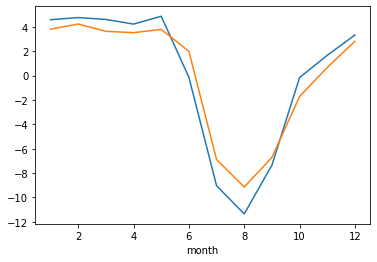

In [105]:
CESM2_ann_late_detrend[0].plot()
CESM2_ann_early_detrend[0].plot()

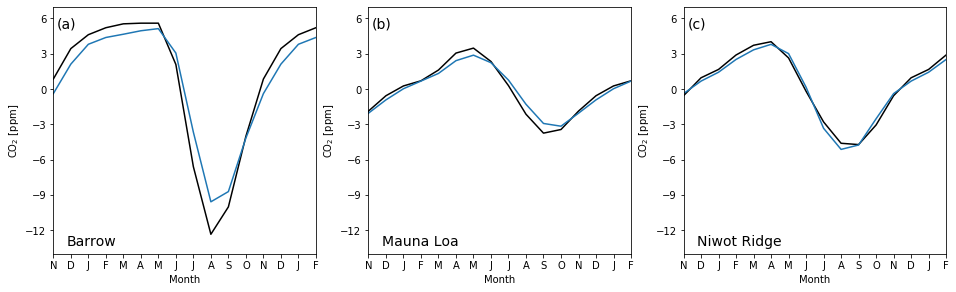

In [75]:
# Late PLOTS -- define late part of record
panel = ['(a)','(b)','(c)','(d)','(e)','(f)'] #to label panels

plt.figure(figsize=[16,10])
for i in range(len(ESRL)):
    late_co2mm  = ESRL[i]['late_co2mm']
    if min(ESRL[i]['year']) < minYear:
        early_co2mm = ESRL[i]['early_co2mm']
  
    plot_early=np.hstack([np.transpose(early_co2mm[10:12]), np.transpose(early_co2mm), np.transpose(early_co2mm[0:2])])
    plot_late=np.hstack([np.transpose(late_co2mm[10:12]), np.transpose(late_co2mm), np.transpose(late_co2mm[0:2])])
    
    # Make subplot
    plt.subplot(2,3,(i+1))  
    plt.figure(1, figsize=(3.5,3))
    #plt.plot(np.arange(0,16), plot_early, 'b')
    plt.plot(np.arange(0,16), plot_late, 'k') ### Note that I pre-pend and append extra months to the figure
    xticklab=(['N', 'D', 'J', 'F', 'M','A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F'])
    ax=plt.gca()
    ax.set_xticks(np.arange(0,16))
    ax.set_xticklabels(xticklab)
    plt.ylabel(r'CO$_2$ [ppm]')
    plt.xlabel('Month')
    plt.xlim([0,15])
    plt.ylim([-14,7])
    ax.set_yticks(np.arange(-12,9,3))
    # add panel label to top left
    plt.text(0.05, 0.93,panel[i], fontsize=14,
         ha='center', va='center', transform=plt.gca().transAxes)
    # add panel label to bottom left
    plt.text(0.05, 0.05,labels[i], fontsize=14,
         ha='left', va='center', transform=plt.gca().transAxes)
    
    # overlay 
    if min(ESRL[i]['year']) < minYear:
        plt.plot(plot_early)
    #plt.plot(plot_late)
    #plt.savefig('BRW_early_late.eps')
    
    
    

In [ ]:
#COPIED FROM ABOVE - NOT YET TESTED
## Need to detrend data

for site, data in CESM1points.items():
    print(site['acronym']+' first year '+str(min(year)) )
    if min(year) < minYear:
        j=np.where(year<(minYear+1))
        early_co2detrend=co2tt.poly3detrend(year[j], month[j], co2[j])
        early_co2mm=co2tt.compute_mm(month[j], early_co2detrend)
        site['early_co2detrend'] = early_co2detrend
        site['early_co2mm'] = early_co2mm
    
    # Repeat for the end of the record
    j=np.where(year>2010)
    late_co2detrend=co2tt.poly3detrend(year[j], month[j], co2[j])
    late_co2mm=co2tt.compute_mm(month[j], late_co2detrend)
    site['late_co2detrend'] = late_co2detrend
    site['late_co2mm'] = late_co2mm

### Up next: plots
#### Similar to above plots:

 - annual cycle with late & early years (if this isn't too messy) for each site
 - Full time series of amplitude at each site

In [ ]:
for site, data in CESM1_ann_cycle.items():
    plot

### Plot seasonal cycle at each site
- This could be done nicer with sharex=True and sharey=True
- https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html

Concatenating data variables into a dictionary

Reading in area data

In [ ]:
#collectionsdir = "/glade/collections/cdg/data/CMIP6/CMIP/NCAR/"
#model          = "CESM2"
#simtype        = "historical"
#varsn          = "gn"
#latest         = "latest"
#ensmem         = "r1i1p1f1"

#areadir    = (collectionsdir+model+"/"+simtype+"/"+ensmem+"/fx/")
#areavar    = "areacella"
#fracvar    = "sftlf"

In [ ]:
#areadata   = xr.open_dataset(areadir+areavar+"/"+varsn+"/"+latest+"/areacella_fx_CESM2_historical_r1i1p1f1_gn.nc")
#fracdata   = xr.open_dataset(areadir+fracvar+"/"+varsn+"/"+latest+"/sftlf_fx_CESM2_historical_r1i1p1f1_gn.nc")

In [ ]:
#area = areadata.areacella
#frac = fracdata.sftlf

### Conversions

In [ ]:
#import metpy as metpy
#from metpy.units import units

In [ ]:
convert = 1.0**6 * 28.966/44.0

#landarea       = area*1.0**6*frac
#landarea.attrs['units']   = 'm^2'

In [ ]:
#print(sims)

In [ ]:
#%%time
#cesm2_kg = data1.CO2

In [ ]:
#print(type(convert))
#print(type(cesm2_kg))

In [ ]:
#%%time
#cesm2_ppm = cesm2_kg*convert
#cesm2_ppm = cesm2_kg.sel(lev=slice(31))*convert

In [ ]:
%%time
#keys_list = list(sims)
#cesm2 = keys_list[0]

#cesm2 = data1.CO2 * convert
#cesm1 = data2.CO2 * convert
#nocrop = data3.CO2 * convert
#nofert = data4.CO2 * convert


#sims_ppm = sims.values() * convert

#for sims, n in sims.items():
#    sims_ppm = n * convert

In [ ]:
#testing out slices
#sims.keys()
#cesm2_kg  = sims['CESM2']
#cesm2slice  = cesm2_kg.sel(time=slice('1970','2014'))

In [ ]:
# to select a grid cell use something like this
# ds.sel(lat=obsLat, lon=obsLon, method='nearest')

In [ ]:
%%time
#This was taking a long time (computer hang?) -- need to confirm whether it works
# Should I pull out information for each site and convert only that? 
#Perhaps I can index using lat, lon, and z from the ERSL list?
#Currently, substting time works more quickly (~5 minutes)
for name, data in sims.items():
    ppm = data.sel(time=slice('1970','2014')) * convert
    ppm.attrs['units'] = 'ppm'
    sims[name] = ppm

In [ ]:
print(sims['CESM2'])

In [ ]:
#print(sims)
#lats=np.array([71.3,19.5,82.5,38.8,55.2,19.7])
#lons=np.array([360-156.61,360-155.6,360-62.5,360-27.4,360-162.7,360-155.0])
#heights=np.array([11.0,3397.0,200.0,19.0,21.3,0.3])
CESM2 = sims['CESM2']
print(type(CESM2))
#print(ESRL[1][2])
#can't figure out how to pull the lats out of the ESRL list. 
#should be the 3rd element in the list, although here it doesn't seem to like the subsetting option. 
#perhaps just write out a list of all lats and a list of lons. 
#print(ESRL)
#print(ESRL[1][2])
#print(CESM2.sel(lat=ESRL[mlo]['lat']))
#look up 'zip'
#mlCESM2 = CESM2.sel(lat=ESRL[mlo:'lat'])

#print(CESM2[lats])

#point = CESM2.sel(lat=slice(lats[0]))
#numsims = len(ESRL)

#What do I iterate over in the for loop???
points = {}
for x in range(6):
#    print(x)
    pointloop = CESM2.sel(lat=lats[x], lon=lons[x], lev=[-1], method="nearest")
    points[x] = pointloop
#    print(pointloop)
print(points)


In [ ]:
x = 0
print(ESRL['names'])
#print(x)
pointloop = CESM2.sel(lat=lats[x], lon=lons[x], lev=[-1], method="nearest")
points[x] = pointloop
print(points)

In [ ]:
print(sims)

In [ ]:
for name, data in sims.items():
    for x in range(6):
        pointloop = data.sel(lat=lats[x], lon=lons[x], lev=[-1], method="nearest")
        points[x] = pointloop
        #how to save points for outter loop
    sims[name]=points

In [ ]:
print(sims)